# Read SUMMA output

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys, pickle, os

# import plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Offline Turbulence Package
import turbpy

# Customize
sns.set_style("whitegrid")
sns.set_context('talk')
%matplotlib inline

In [2]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists
# Unix
if 'linux' in sys.platform:
    dirPre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dirPre = '/Users/karllapo/gdrive/'

dirProj = dirPre + 'SnowHydrology/proj/ModTsfc/'
dirPrint = dirProj + 'Graphics'
dirData = dirProj + 'data'

## Functions to quickly evaluate all model output

In [3]:
def evalBiasTs(ax, dsDict, obs, labels, ls, lcolor):
    # Tsurf scatter plot
    hours = np.arange(0, 24)
    for ex in sorted(dsDict.keys()):
        ax.plot(dsDict[ex].scalarSurfaceTemp - 273.15, obs.Tsrf, '.',
                label=labels[ex],
                color=lcolor[ex])
    ax.plot([-30, 0], [-30, 0], 'k--')
    ax.set_xlim(-30, 0)
    ax.set_ylim(-30, 0)
    ax.set_xlabel('Modeled T ($^{\circ}$)')
    ax.set_ylabel('Observed T ($^{\circ}$)')
    ax.legend(loc='best')

## Forcing data

In [4]:
os.chdir(dirData)
CDP = xr.open_dataset('CDP.ModTsfc.nc')

# --------------------------------------------------------------------------------------------
# Select only the model forcing period
CDP = CDP.loc[dict(time = slice(datetime(2005, 10, 1), datetime(2006, 9, 1)))]

## Model output

## Check out the layer runs

In [5]:
os.chdir('/Users/karllapo/gdrive/SnowHydrology/proj/ModTsfc/summa/ModTsfc_summa/output/layers/CDP/')
layerThin = xr.open_dataset('layerThick_2005-2006_thinLayer_1.nc')
layerThick = xr.open_dataset('layerThin_2005-2006_thickLayer_1.nc')
jrdn1991 = xr.open_dataset('jrdn1991_2005-2006_jrdn1991_1.nc')
clm2010 = xr.open_dataset('CLM_2010_2005-2006_CLM_2010_1.nc')

layerExp = {'layerThin': layerThin,
            'layerThick': layerThick,
            'jrdn1991': jrdn1991,
            'clm2010': clm2010
           }
layerExpLabel = {'layerThin': 'UEB-like',
                 'layerThick': 'VIC-like',
                 'clm2010': 'CLM-like',
                 'jrdn1991': 'SNTHERM-like',
                }

layerExpLineStyle = {'layerThin': '-',
                     'layerThick': '-',
                     'clm2010': '-',
                     'jrdn1991': '-',
                }

color = kgraph.SRON(4)
layerExpColor = {'layerThin': color[0],
                 'layerThick': color[1],
                 'clm2010': color[2],
                 'jrdn1991': color[3],
                }

# There is some trouble reading in the summa netcdf time, so let's just force this to be correct
for l in layerExp:
    layerExp[l]['time'] = CDP.time.values

## Check out the thermal conductivity runs

In [6]:
os.chdir('/Users/karllapo/gdrive/SnowHydrology/proj/ModTsfc/summa/ModTsfc_summa/output/thermalCond/CDP/')

thCond = {}
thCondLabel = {}
thCondLineStyle = {}
thCondColor = {}

arrayExpID = ['tyen1965', 'melr1977', 'jrdn1991', 'smnv2000']
expIDAppend = ['Mid', 'Low', 'High']
expIDAppendLineStyle = {'Mid': '-',
                        'Low': '--',
                        'High': ':'}
color = kgraph.SRON(4)

for n, expID in enumerate(arrayExpID):
    for append in expIDAppend:
        expName = expID + append
        thCond[expName] = xr.open_dataset(expName + '_2005-2006_' + expName + '_1.nc')
#         thCondLabel[expName] = expID + ' ' + append + ' conductivity'
        thCondLabel[expName] = ''

        thCondLineStyle[expName] = expIDAppendLineStyle[append]
        
        thCondColor[expName] = color[n]
    
# There is some trouble reading in the summa netcdf time, so let's just force this to be correct
for t in thCond:
    thCond[t]['time'] = CDP.time.values

## Check out the longwave bias runs

In [7]:
os.chdir('/Users/karllapo/gdrive/SnowHydrology/proj/ModTsfc/summa/ModTsfc_summa/output/longwaveBias/CDP/')

biasLW = {}
arrayExpID = ['lowLW', 'obsLW', 'highLW']
color = kgraph.SRON(3)

for expID in arrayExpID:
    biasLW[expID] = xr.open_dataset(expID + '_2005-2006_' + expID + '_1.nc')

biasLWLabel = {'lowLW': '-20 Wm-2 bias',
               'obsLW': '0 Wm-2 bias', 
               'highLW': '+20Wm-2 bias'
              }
biasLWColor = {'lowLW': color[0],
               'obsLW': color[1], 
               'highLW': color[2]
              }
biasLWLineStyle = {'lowLW': '-',
                   'obsLW': '-', 
                   'highLW': '-'
                  }

# There is some trouble reading in the summa netcdf time, so let's just force this to be correct
for b in biasLW:
    biasLW[b]['time'] = CDP.time.values

##  Check out the turbulence stability runs

In [8]:
os.chdir('/Users/karllapo/gdrive/SnowHydrology/proj/ModTsfc/summa/ModTsfc_summa/output/stability/CDP/')

stab = {}
stabLabel = {}
stabLineStyle = {}
stabColor = {}
expIDAppend = ['Low', 'Mid', 'High']
arrayExpID = ['standard', 'louisinv', 'mahrtexp']
expIDLineStyle = {'Mid': '-',
                  'Low': '--',
                  'High': ':'}
color = kgraph.SRON(3)

for n, expID in enumerate(arrayExpID):
    for append in expIDAppend:
        expName = expID + append
        stab[expName] = xr.open_dataset(expName + '_2005-2006_' + expName + '_1.nc')
        stabLabel[expName] = ''
#         stabLabel[expName] = expID + ' ' + append + ' z0'
        stabLineStyle[expName] = expIDLineStyle[append]
        stabColor[expName] = color[n]
        
# There is some trouble reading in the summa netcdf time, so let's just force this to be correct
for b in stab:
    stab[b]['time'] = CDP.time.values

//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


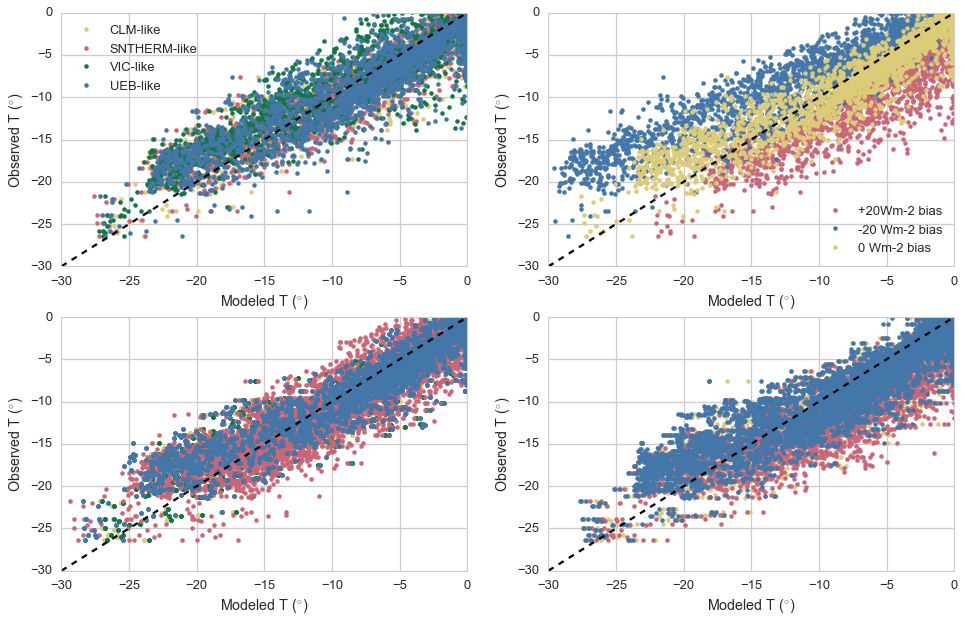

In [9]:
fig, axes = plt.subplots(2, 2, figsize= (16, 10))
axes = axes.flatten()

ax = axes[0]
tempDS = {}
for n in layerExp:
    tempDS[n] = layerExp[n]
    tempDS[n]['scalarSurfaceTemp'] = layerExp[n]['scalarSurfaceTemp'].where((CDP.SP == 1)
                                                                            & (tempDS[n]['scalarSWE'] > 0))
evalBiasTs(ax, tempDS, CDP, layerExpLabel, layerExpLineStyle, layerExpColor)

ax = axes[1]
tempDS = {}
for n in biasLW:
    tempDS[n] = biasLW[n]
    tempDS[n]['scalarSurfaceTemp'] = biasLW[n]['scalarSurfaceTemp'].where((CDP.SP == 1)
                                                                            & (tempDS[n]['scalarSWE'] > 0))
evalBiasTs(ax, tempDS, CDP,  biasLWLabel, biasLWLineStyle, biasLWColor)

ax = axes[2]
tempDS = {}
for n in thCond:
    tempDS[n] = thCond[n]
    tempDS[n]['scalarSurfaceTemp'] = thCond[n]['scalarSurfaceTemp'].where((CDP.SP == 1)
                                                                         & (tempDS[n]['scalarSWE'] > 0))
evalBiasTs(ax, tempDS, CDP, thCondLabel, thCondLineStyle, thCondColor)

ax = axes[3]
tempDS = {}
for n in stab:
    tempDS[n] = stab[n]
    tempDS[n]['scalarSurfaceTemp'] = stab[n]['scalarSurfaceTemp'].where((CDP.SP == 1)
                                                                            & (tempDS[n]['scalarSWE'] > 0))
evalBiasTs(ax, tempDS, CDP, stabLabel, stabLineStyle, stabColor)

os.chdir(dirPrint)
# fig.savefig('ModTsfc.WSC17.DiurnalTs_All.pdf')
# fig.savefig('ModTsfc.WSC17.DiurnalTs_All.png')

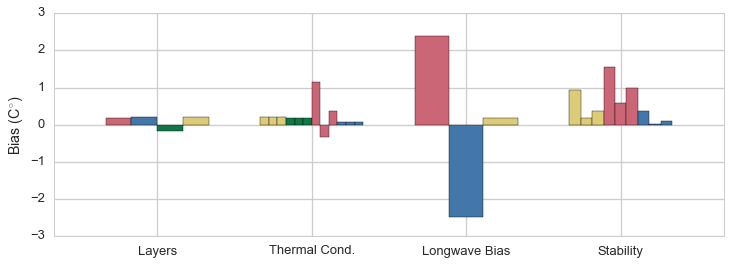

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

for n, name in enumerate(layerExp):
    tempDS = layerExp[name]
    tempDS['scalarSurfaceTemp'] = layerExp[name]['scalarSurfaceTemp'].where((CDP.SP == 1)
                                                                            & (tempDS['scalarSWE'] > 0))
    ax.bar(n / len(layerExp) - .5, np.mean(( tempDS.scalarSurfaceTemp - 273.15) - CDP.Tsrf),
           color=layerExpColor[name], width= 1 / len(layerExp))

    
for n, name in enumerate(sorted(thCond.keys())):
    tempDS = thCond[name]
    tempDS['scalarSurfaceTemp'] = thCond[name]['scalarSurfaceTemp'].where((CDP.SP == 1)
                                                                            & (tempDS['scalarSWE'] > 0))
    ax.bar(n / len(thCond) + 1, np.mean(( tempDS.scalarSurfaceTemp - 273.15) - CDP.Tsrf),
           color=thCondColor[name], width= 1 / len(thCond))
    
for n, name in enumerate(sorted(biasLW.keys())):
    tempDS = biasLW[name]
    tempDS['scalarSurfaceTemp'] = biasLW[name]['scalarSurfaceTemp'].where((CDP.SP == 1)
                                                                            & (tempDS['scalarSWE'] > 0))
    ax.bar(n / len(biasLW) + 2.5, np.mean(( tempDS.scalarSurfaceTemp - 273.15) - CDP.Tsrf),
           color=biasLWColor[name], width= 1 / len(biasLW))
    
for n, name in enumerate(sorted(stab.keys())):
    tempDS = stab[name]
    tempDS['scalarSurfaceTemp'] = stab[name]['scalarSurfaceTemp'].where((CDP.SP == 1)
                                                                            & (tempDS['scalarSWE'] > 0))
    ax.bar(n / len(stab) + 4, np.mean(( tempDS.scalarSurfaceTemp - 273.15) - CDP.Tsrf),
           color=stabColor[name], width= 1 / len(stab))

# Formatting
ax.set_ylabel('Bias (C$^{\circ}$)')
ax.set_xticks((0, 1.5, 3, 4.5))
ax.set_xticklabels(['Layers', 'Thermal Cond.', 'Longwave Bias', 'Stability'])
ax.set_xlim(-1, 5.5)

os.chdir(dirPrint)
fig.savefig('ModTsfc.WSC17.BiasSummary.pdf')

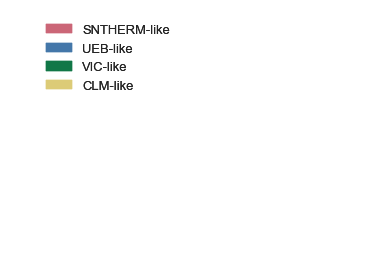

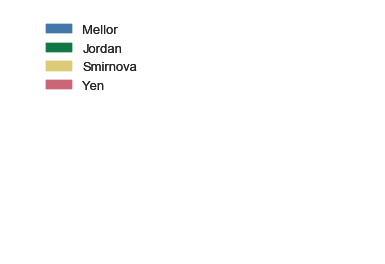

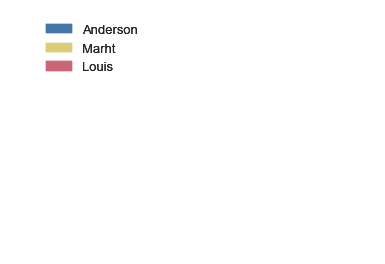

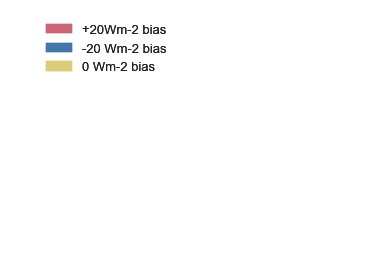

In [61]:
os.chdir(dirPrint)

# Layers
fig, ax = plt.subplots(1,1)
ax.axis('off')

color = kgraph.SRON(4)
h1 = [matplotlib.patches.Patch(color=layerExpColor[gr], label=layerExpLabel[gr]) \
          for gr in layerExpLabel]
leg = plt.legend(handles=h1,loc='upper left')
leg.get_frame().set_facecolor('w')
plt.gca().add_artist(leg)
fig.savefig('ModTsfc.WSC17.Layers_leg.pdf')

# Thermal Conductivity
fig, ax = plt.subplots(1,1)
ax.axis('off')

thCondLabel_Params = {'tyen1965': 'Yen', 'melr1977': 'Mellor', 'jrdn1991': 'Jordan', 'smnv2000': 'Smirnova'}
thCondColor_Params = {}
for n, expID in enumerate(thCondLabel_Params):
        thCondColor_Params[expID] = color[n]
h1 = [matplotlib.patches.Patch(color=thCondColor_Params[gr], label=thCondLabel_Params[gr]) \
          for gr in thCondLabel_Params]
leg = plt.legend(handles=h1,loc='upper left')
leg.get_frame().set_facecolor('w')
plt.gca().add_artist(leg)
fig.savefig('ModTsfc.WSC17.thCond_leg.pdf')

# Stability
fig, ax = plt.subplots(1,1)
ax.axis('off')

stabLabel_Params = {'standard': 'Anderson', 'louisinv': 'Louis', 'mahrtexp': 'Marht'}
stabColor_Params = {}
color = kgraph.SRON(3)
for n, expID in enumerate(stabLabel_Params):
        stabColor_Params[expID] = color[n]

h1 = [matplotlib.patches.Patch(color=stabColor_Params[gr], label=stabLabel_Params[gr]) \
          for n, gr in enumerate(stabLabel_Params)]
leg = plt.legend(handles=h1,loc='upper left')
leg.get_frame().set_facecolor('w')
plt.gca().add_artist(leg)
fig.savefig('ModTsfc.WSC17.stab_leg.pdf')

# Longwave bias
fig, ax = plt.subplots(1,1)
ax.axis('off')

color = kgraph.SRON(3)
h1 = [matplotlib.patches.Patch(color=biasLWColor[gr], label=biasLWLabel[gr]) \
          for n, gr in enumerate(biasLWLabel)]
leg = plt.legend(handles=h1,loc='upper left')
leg.get_frame().set_facecolor('w')
plt.gca().add_artist(leg)
fig.savefig('ModTsfc.WSC17.biasLW_leg.pdf')
